In [1]:
import sys
import os

sys.path.append("/home/mdafifal.mamun/notebooks/triagerX")

In [2]:
import pandas as pd
from transformers import RobertaModel, RobertaTokenizer, RobertaConfig
from triagerx.dataset.text_processor import TextProcessor
import torch

In [3]:
from tqdm import tqdm
tqdm.pandas()

In [4]:
dataset_path = "/home/mdafifal.mamun/notebooks/triagerX/data/openj9/openj9_08122024.csv"
df = pd.read_csv(dataset_path)
df = df.rename(columns={"assignees": "owner", "issue_body": "description"})
df = df[df["owner"].notna()]

num_cv = 10
block = 9
# sample_threshold=20 # Threshold to filter developers
samples_per_block = len(df) // num_cv

sliced_df = df[: samples_per_block * (block + 1)]
df_train = sliced_df[: samples_per_block * block]
df_test = sliced_df[samples_per_block * block : samples_per_block * (block + 1)]

sample_threshold = 20
developers = df_train["owner"].value_counts()
filtered_developers = developers.index[developers >= sample_threshold]
df_train = df_train[df_train["owner"].isin(filtered_developers)]

train_owners = set(df_train["owner"])
test_owners = set(df_test["owner"])

unwanted = list(test_owners - train_owners)

df_test = df_test[~df_test["owner"].isin(unwanted)]

lbl2idx = {}
idx2lbl = {}

train_owners = sorted(train_owners)

for idx, dev in enumerate(train_owners):
    lbl2idx[dev] = idx
    idx2lbl[idx] = dev

df_train["owner_id"] = df_train["owner"].apply(lambda owner: lbl2idx[owner])
df_test["owner_id"] = df_test["owner"].apply(lambda owner: lbl2idx[owner])
df_test = TextProcessor.prepare_dataframe(df_test, False, False, True, False, False)

print(f"Training data: {len(df_train)}, Validation data: {len(df_test)}")
print(f"Number of train developers: {len(df_train.owner.unique())}")
print(f"Number of test developers: {len(df_test.owner.unique())}")

100%|██████████| 385/385 [00:00<00:00, 589130.62it/s]
2025-07-06 19:10:42.565 | INFO     | triagerx.dataset.text_processor:prepare_dataframe:58 - Cleaning text...
100%|██████████| 385/385 [00:00<00:00, 1393.32it/s]
2025-07-06 19:10:42.846 | INFO     | triagerx.dataset.text_processor:prepare_dataframe:71 - Adding description...
100%|██████████| 385/385 [00:00<00:00, 88120.44it/s]

Training data: 3413, Validation data: 385
Number of train developers: 50
Number of test developers: 32


In [5]:
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer
import numpy as np

class TriageDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        tokenizer: RobertaTokenizer,
        feature: str = "text",
        target: str = "owner_id",
        max_tokens: int = 256,
    ):
        print("Generating torch dataset...")
        self.tokenizer = tokenizer
        self.labels = [label for label in df[target]]
        print("Tokenizing texts...")
        self.texts = [
            self.tokenizer(
                row[feature],
                padding="max_length",
                max_length=max_tokens,
                truncation=True,
                return_tensors="pt",
            )
            for _, row in df.iterrows()
        ]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [6]:
import numpy as np
import pandas as pd
from loguru import logger
from torch.utils.data import Dataset
from transformers import PreTrainedTokenizer

from triagerx.model.prediction_model import PredictionModel
from triagerx.dataset.text_processor import TextProcessor


def process_data_for_triagerx(
        text,
        model: PredictionModel,
        max_length: int = 256,
        device="cuda"
    ):
        
        text = TextProcessor.clean_text(text)

        tokenizer1 = model.tokenizer(0)
        tokenizer2 = model.tokenizer(1)

        tok1 = tokenizer1(
                    text,
                    padding="max_length",
                    max_length=max_length,
                    truncation=True,
                    return_tensors="pt",
                )
        
        input_ids1 = tok1["input_ids"].to(device)
        mask1 = tok1["attention_mask"].to(device)
        
        
        tok2 = tokenizer2(
                    text,
                    padding="max_length",
                    max_length=max_length,
                    truncation=True,
                    return_tensors="pt",
                )
        
        input_ids2 = tok2["input_ids"].to(device)
        mask2 = tok2["attention_mask"].to(device)

        return input_ids1, mask1, input_ids2, mask2


In [7]:
import torch
from loguru import logger
from torch import nn
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    PreTrainedTokenizer,
)

from triagerx.model.prediction_model import PredictionModel


class FCNTransformer(PredictionModel):
    def __init__(
        self,
        output_size,
        unfrozen_layers,
        dropout=0.1,
        base_model="microsoft/deberta-large",
        max_tokens=512,
        label_map=None,
    ) -> None:
        super(FCNTransformer, self).__init__()
        self.base_model = AutoModelForSequenceClassification.from_pretrained(
            base_model, num_labels=output_size
        )
        self._tokenizer = AutoTokenizer.from_pretrained(base_model)
        self._label_map = label_map
        self._max_tokens = max_tokens

        if unfrozen_layers == -1:
            logger.debug("Initiating full training...")
        else:
            logger.debug(
                f"Freezing {self.base_model.config.num_hidden_layers - unfrozen_layers} layers"
            )
            # Freeze embedding layers
            for p in self.base_model.embeddings.parameters():
                p.requires_grad = False

            # Freeze encoder layers till last {unfrozen_layers} layers
            for i in range(
                0, self.base_model.config.num_hidden_layers - unfrozen_layers
            ):
                for p in self.base_model.encoder.layer[i].parameters():
                    p.requires_grad = False

    def forward(self, input_ids, attention_mask=None):
        # inputs = {
        #     key: value.squeeze(1).to(next(self.parameters()).device)
        #     for key, value in inputs.items()
        # }

        base_out = self.base_model(input_ids=input_ids, attention_mask=attention_mask)

        return base_out.logits

    def tokenizer(self) -> PreTrainedTokenizer:
        return self._tokenizer

    def tokenize_text(self, text):
        return self._tokenizer(
            text,
            padding="max_length",
            max_length=self._max_tokens,
            truncation=True,
            return_tensors="pt",
        )

    def get_label_map(self):
        return self._label_map

In [8]:
import torch
from loguru import logger
from torch import nn
from transformers import AutoModel, AutoTokenizer, PreTrainedTokenizer

from triagerx.model.prediction_model import PredictionModel


class CNNTransformer(PredictionModel):
    def __init__(
        self,
        output_size,
        unfrozen_layers,
        num_classifiers,
        dropout=0.1,
        base_model="microsoft/deberta-large",
        max_tokens=512,
        num_filters=256,
        label_map=None,
    ) -> None:
        super(CNNTransformer, self).__init__()
        self.base_model = AutoModel.from_pretrained(
            base_model, output_hidden_states=True
        )
        self._tokenizer = AutoTokenizer.from_pretrained(base_model)
        self._label_map = label_map

        if unfrozen_layers == -1:
            logger.debug("Initiating full training...")
        else:
            logger.debug(
                f"Freezing {self.base_model.config.num_hidden_layers - unfrozen_layers} layers"
            )
            # Freeze embedding layers
            for p in self.base_model.embeddings.parameters():
                p.requires_grad = False

            # Freeze encoder layers till last {unfrozen_layers} layers
            for i in range(
                0, self.base_model.config.num_hidden_layers - unfrozen_layers
            ):
                for p in self.base_model.encoder.layer[i].parameters():
                    p.requires_grad = False

        filter_sizes = [3, 4, 5, 6]
        self._num_filters = num_filters
        self._num_classifiers = num_classifiers
        self._max_tokens = max_tokens
        self._embed_size = self.base_model.config.hidden_size
        self.unfrozen_layers = unfrozen_layers
        self.conv_blocks = nn.ModuleList(
            [
                nn.ModuleList(
                    [
                        nn.Sequential(
                            nn.Conv2d(1, self._num_filters, (K, self._embed_size)),
                            nn.BatchNorm2d(self._num_filters),
                            nn.ReLU(),
                            nn.Flatten(),
                            nn.MaxPool1d(self._max_tokens - (K - 1)),
                            nn.Flatten(start_dim=1),
                        )
                        for K in filter_sizes
                    ]
                )
                for _ in range(self._num_classifiers)
            ]
        )

        self.classifiers = nn.ModuleList(
            [
                nn.Linear(len(filter_sizes) * self._num_filters, output_size)
                for _ in range(self._num_classifiers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask=None):
        # inputs = {
        #     key: value.squeeze(1).to(next(self.parameters()).device)
        #     for key, value in inputs.items()
        # }
        outputs = []

        base_out = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        # pooler_out = base_out.last_hidden_state.squeeze(0)
        hidden_states = base_out.hidden_states[-self._num_classifiers :]

        for i in range(self._num_classifiers):
            batch_size, sequence_length, hidden_size = hidden_states[i].size()
            x = [
                conv(hidden_states[i].view(batch_size, 1, sequence_length, hidden_size))
                for conv in self.conv_blocks[i]
            ]
            # Concatanating outputs of the conv block of different filter sizes
            feature_map = torch.cat(x, dim=1)
            x = self.dropout(feature_map)
            x = self.classifiers[i](x)

            outputs.append(x)

        return outputs

    def tokenizer(self) -> PreTrainedTokenizer:
        return self._tokenizer

    def tokenize_text(self, text):
        return self._tokenizer(
            text,
            padding="max_length",
            max_length=self._max_tokens,
            truncation=True,
            return_tensors="pt",
        )

    def get_label_map(self):
        return self._label_map


In [9]:
import torch
from loguru import logger
from torch import nn
from transformers import AutoModel, AutoTokenizer, PreTrainedTokenizer

from triagerx.model.prediction_model import PredictionModel


class TriagerxModel(PredictionModel):
    def __init__(
        self,
        output_size,
        unfrozen_layers,
        num_classifiers,
        base_models,
        dropout=0.1,
        max_tokens=512,
        num_filters=256,
        label_map=None,
    ) -> None:
        super(TriagerxModel, self).__init__()

        # Initialize base models and their respective tokenizers
        logger.debug(f"Loading base transformer models: {base_models}")
        self.base_models = nn.ModuleList(
            [
                AutoModel.from_pretrained(model, output_hidden_states=True)
                for model in base_models
            ]
        )
        self.tokenizers = [
            AutoTokenizer.from_pretrained(model) for model in base_models
        ]
        self._label_map = label_map

        if unfrozen_layers == -1:
            logger.debug("Initiating full training...")
        else:
            # Freeze embedding layers for all models
            for base_model in self.base_models:
                logger.debug(
                    f"Freezing {base_model.config.num_hidden_layers - unfrozen_layers} layers"
                )
                for p in base_model.embeddings.parameters():
                    p.requires_grad = False

            # Freeze encoder layers until the last `unfrozen_layers` layers for all models
            for base_model in self.base_models:
                for i in range(
                    0, base_model.config.num_hidden_layers - unfrozen_layers
                ):
                    for p in base_model.encoder.layer[i].parameters():
                        p.requires_grad = False

        # Define filter sizes for convolution layers
        filter_sizes = [3, 4, 5, 6]
        self._num_filters = num_filters
        self._num_classifiers = num_classifiers
        self._max_tokens = max_tokens
        self.unfrozen_layers = unfrozen_layers

        # Calculate total embedding size by summing hidden sizes of all base models
        embed_sizes = [base_model.config.hidden_size for base_model in self.base_models]
        self._embed_size = sum(embed_sizes)

        # Initialize convolutional blocks for each classifier
        self.conv_blocks = nn.ModuleList(
            [
                nn.ModuleList(
                    [
                        nn.Sequential(
                            nn.Conv2d(
                                1,
                                self._num_filters,
                                (K, self._embed_size),
                            ),
                            nn.BatchNorm2d(self._num_filters),
                            nn.ReLU(),
                            nn.Flatten(),
                            nn.MaxPool1d(self._max_tokens - (K - 1)),
                            nn.Flatten(start_dim=1),
                        )
                        for K in filter_sizes
                    ]
                )
                for _ in range(self._num_classifiers)
            ]
        )

        # Initialize classifiers for each classifier block
        self.classifiers = nn.ModuleList(
            [
                nn.Linear(len(filter_sizes) * self._num_filters, output_size)
                for _ in range(self._num_classifiers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

        # Initialize learnable weights for each base model
        self.model_weights = nn.ParameterList(
            [nn.Parameter(torch.ones(self._num_classifiers)) for _ in self.base_models]
        )
        self.classifier_weights = nn.Parameter(torch.ones(self._num_classifiers))

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2):
        # Process input data for each base model
        # inputs = [
        #     {
        #         key: value.squeeze(1).to(next(self.parameters()).device)
        #         for key, value in model_inputs.items()
        #     }
        #     for model_inputs in inputs
        # ]

        hidden_states = []

        # Extract hidden states from each base model
        for idx, base_model in enumerate(self.base_models):
            ids = None
            mask = None

            if idx == 0:
                ids = input_ids1
                mask = attention_mask1

            if idx == 1:
                ids = input_ids2
                mask = attention_mask2


            base_out = base_model(
                input_ids=ids,
                attention_mask=mask,
            )
            hidden_states.append(base_out.hidden_states[-self._num_classifiers :])

        outputs = []

        # Concatenate hidden states and apply convolutional blocks and classifiers
        for i in range(self._num_classifiers):
            # Apply learnable weights to hidden states from each base model
            weighted_hidden_states = [
                self.model_weights[idx][i] * hidden_states[idx][i]
                for idx in range(len(self.base_models))
            ]
            concatenated_hidden_states = torch.cat(weighted_hidden_states, dim=-1)
            batch_size, sequence_length, hidden_size = concatenated_hidden_states.size()
            x = [
                conv(
                    concatenated_hidden_states.view(
                        batch_size, 1, sequence_length, hidden_size
                    )
                )
                for conv in self.conv_blocks[i]
            ]
            # Concatenating outputs of the convolutional blocks of different filter sizes
            feature_map = torch.cat(x, dim=1)
            x = self.dropout(feature_map)
            x = self.classifier_weights[i] * self.classifiers[i](x)

            outputs.append(x)

        return outputs

    def tokenizer(self, model_idx) -> PreTrainedTokenizer:
        # Return the tokenizer for the specified base model index
        if model_idx < 0 or model_idx >= len(self.tokenizers):
            raise ValueError(
                f"Invalid model index, choose between 0 and {len(self.tokenizers) - 1}"
            )
        return self.tokenizers[model_idx]

    def tokenize_text(self, text):
        return [
            tokenizer(
                text,
                padding="max_length",
                max_length=self._max_tokens,
                truncation=True,
                return_tensors="pt",
            )
            for tokenizer in self.tokenizers
        ]

    def get_label_map(self):
        return self._label_map


In [10]:
def model_output(inputs, mask):
  model.eval()

  with torch.no_grad():
    output = model(inputs, mask)
  
  return None

In [11]:
def get_data(owner_id, sample_index):
    sample = df_test[df_test["owner_id"] == owner_id].iloc[sample_index]

    return sample.owner, sample.text, sample.text2

In [12]:
import numpy as np
import pandas as pd
from loguru import logger
from torch.utils.data import Dataset
from transformers import PreTrainedTokenizer

from triagerx.model.prediction_model import PredictionModel
from triagerx.dataset.text_processor import TextProcessor


def process_data_general(
        text,
        model: PredictionModel,
        max_length: int = 256,
        device="cuda"
    ):
        
        text = TextProcessor.clean_text(text)

        tok1 = model.tokenize_text(
                    text)
        
        input_ids1 = tok1["input_ids"].to(device)
        mask1 = tok1["attention_mask"].to(device)

        return input_ids1, mask1

def process_data_for_triagerx(
        text,
        model: PredictionModel,
        max_length: int = 256,
        device="cuda"
    ):
        
        text = TextProcessor.clean_text(text)

        tokenizer1 = model.tokenizer(0)
        tokenizer2 = model.tokenizer(1)

        tok1 = tokenizer1(
                    text,
                    padding="max_length",
                    max_length=max_length,
                    truncation=True,
                    return_tensors="pt",
                )
        
        input_ids1 = tok1["input_ids"].to(device)
        mask1 = tok1["attention_mask"].to(device)
        
        
        tok2 = tokenizer2(
                    text,
                    padding="max_length",
                    max_length=max_length,
                    truncation=True,
                    return_tensors="pt",
                )
        
        input_ids2 = tok2["input_ids"].to(device)
        mask2 = tok2["attention_mask"].to(device)

        return input_ids1, mask1, input_ids2, mask2


In [13]:
# Define model output
def model_output_triagerx(id1, m1, id2, m2):
  model.eval()
  output = model(id1, m1, id2, m2)
  return None

In [15]:
# model = TriagerxModel(
#     output_size=len(df_train.owner.unique()),
#     unfrozen_layers=3,
#     num_classifiers=3,
#     base_models=["microsoft/deberta-base", "roberta-base"],
#     dropout=0.2,
#     max_tokens=256,
#     num_filters=256,
#     label_map=None,
# )
# base_model_name = "microsoft/codebert-base"
# model = CNNTransformer(output_size=len(df_train.owner_id.unique()), unfrozen_layers=-1, num_classifiers=1, dropout=0.1, base_model=base_model_name, max_tokens=256)
# # model = FCNTransformer(output_size=len(df_train.owner_id.unique()), unfrozen_layers=-1, dropout=0.1, base_model=base_model_name, max_tokens=256)
# tokenizer = AutoTokenizer.from_pretrained(base_model_name)

base_model_name = "bert-large-uncased"
model = FCNTransformer(output_size=len(df_train.owner_id.unique()), unfrozen_layers=-1, dropout=0.1, base_model=base_model_name, max_tokens=256)
# model = CNNTransformer(output_size=len(df_train.owner_id.unique()), unfrozen_layers=-1, num_classifiers=1, dropout=0.1, base_model=base_model_name, max_tokens=256)
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

is_trx = True if isinstance(model, TriagerxModel) else False
print(f"Model type: {type(model).__name__}, TriagerX: {is_trx}")

# Count parameers
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-07-06 19:11:02.593 | DEBUG    | __main__:__init__:32 - Initiating full training...


Model type: FCNTransformer, TriagerX: False
Total parameters: 335193138


In [16]:
import time
import torch
import psutil
import numpy as np
import random

def measure_real_data_inference(
    model, df_test, n_samples=20, device="cpu", seed=42, triagerx=False,
):
    # Set seeds for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Move model to desired device
    model = model.to(device).eval()

    # Sample fixed text inputs
    samples = df_test.sample(n=n_samples, random_state=seed)

    times = []
    mems = []

    # Warmup with the first example
    text = samples.iloc[0].text
    with torch.no_grad():
        if triagerx:
            i1, m1, i2, m2 = process_data_for_triagerx(text, model, device=device)
            _ = model_output_triagerx(i1, m1, i2, m2)
        else:
            i1, m1 = process_data_general(text, model, device=device)
            _ = model_output(i1, m1)

    # Main loop for measurements
    for _, row in samples.iterrows():
        text = row.text
        with torch.no_grad():
            if triagerx:
                input_ids, mask1, input_ids2, mask2 = process_data_for_triagerx(text, model, device=device)
            else:
                input_ids, mask1 = process_data_general(text, model, device=device)

        # Clear GPU memory tracking
        if device == "cuda":
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()

        # Track CPU memory usage
        process = psutil.Process()
        start_mem = process.memory_info().rss
        start_time = time.time()

        with torch.no_grad():
            if triagerx:
                _ = model_output_triagerx(input_ids, mask1, input_ids2, mask2)
            else:
                _ = model_output(input_ids, mask1)

        end_time = time.time()
        end_mem = process.memory_info().rss

        elapsed = end_time - start_time
        mem_used = (
            torch.cuda.max_memory_allocated(device) if device == "cuda"
            else end_mem - start_mem
        )

        times.append(elapsed)
        mems.append(mem_used)

    return {
        "avg_time_s": np.mean(times),
        "std_time_s": np.std(times),
        "avg_mem_MB": np.mean(mems) / (1024 ** 2),
        "std_mem_MB": np.std(mems) / (1024 ** 2),
    }

# Example usage:

# Choose the number of samples
N_SAMPLES = 50

# Evaluate on CPU
cpu_stats = measure_real_data_inference(
    model, df_test, n_samples=N_SAMPLES, device="cpu", triagerx=is_trx
)
print("✅ CPU stats:", cpu_stats)

# Evaluate on GPU (if available)
if torch.cuda.is_available():
    gpu_stats = measure_real_data_inference(
        model, df_test, n_samples=N_SAMPLES, device="cuda", triagerx=is_trx
    )
    print("✅ GPU stats:", gpu_stats)
else:
    print("⚠️ CUDA not available.")


✅ CPU stats: {'avg_time_s': 1.3295201110839843, 'std_time_s': 0.02240467009176996, 'avg_mem_MB': 0.31890625, 'std_mem_MB': 2.5904387231355837}
✅ GPU stats: {'avg_time_s': 0.013940186500549316, 'std_time_s': 0.003659504315265692, 'avg_mem_MB': 1302.57568359375, 'std_mem_MB': 0.0}



RoBERTa Large CNN

✅ CPU stats: {'avg_time_s': 2.2028946113586425, 'std_time_s': 0.011906460170957691, 'avg_mem_MB': 0.539375, 'std_mem_MB': 2.2255401764848997}

✅ GPU stats: {'avg_time_s': 0.020845632553100586, 'std_time_s': 0.0012355331441729906, 'avg_mem_MB': 1457.25927734375, 'std_mem_MB': 0.0}


RoBERTA Large FCN

✅ CPU stats: {'avg_time_s': 1.7847563123703003, 'std_time_s': 0.03366890922397835, 'avg_mem_MB': 0.00015625, 'std_mem_MB': 0.0010937499999999999}

✅ GPU stats: {'avg_time_s': 0.017112302780151366, 'std_time_s': 0.0006271557303834676, 'avg_mem_MB': 1378.92822265625, 'std_mem_MB': 0.0}

==

Deberta Large CNN

CPU stats: {'avg_time_s': 2.7802979230880736, 'std_time_s': 0.01736469925878027, 'avg_mem_MB': 0.00171875, 'std_mem_MB': 0.010941963375007246}

GPU stats: {'avg_time_s': 0.042093119621276855, 'std_time_s': 0.0019672685743898958, 'avg_mem_MB': 1631.80517578125, 'std_mem_MB': 0.0}


Deberta Large FCN

✅ CPU stats: {'avg_time_s': 2.711175866127014, 'std_time_s': 0.0366428483505478, 'avg_mem_MB': 0.3803125, 'std_mem_MB': 7.246974245695471}

✅ GPU stats: {'avg_time_s': 0.04386535167694092, 'std_time_s': 0.0024947264082693967, 'avg_mem_MB': 1617.78759765625, 'std_mem_MB': 0.0}

==

TriagerX

✅ CPU stats: {'avg_time_s': 2.219985857009888, 'std_time_s': 0.020313800895039587, 'avg_mem_MB': 0.6359375, 'std_mem_MB': 4.201197789465636}

✅ GPU stats: {'avg_time_s': 0.02549185752868653, 'std_time_s': 0.0004927418658639433, 'avg_mem_MB': 1133.740234375, 'std_mem_MB': 0.0}


==

BERT Large FCN

CPU stats: {'avg_time_s': 1.7694211530685424, 'std_time_s': 0.016060059887166214, 'avg_mem_MB': 0.32046875, 'std_mem_MB': 1.0771612993622404}

✅ GPU stats: {'avg_time_s': 0.018230079650878905, 'std_time_s': 0.0009198533153069563, 'avg_mem_MB': 1310.3837890625, 'std_mem_MB': 0.0}

BERT Large CNN

✅ CPU stats: {'avg_time_s': 1.938598370552063, 'std_time_s': 0.017069017770537306, 'avg_mem_MB': 0.568984375, 'std_mem_MB': 2.2541401538617674}

✅ GPU stats: {'avg_time_s': 0.02120237350463867, 'std_time_s': 0.0021111691433829687, 'avg_mem_MB': 1344.47216796875, 'std_mem_MB': 0.0}

CodeBERT CNN

✅ CPU stats: {'avg_time_s': 0.4298019790649414, 'std_time_s': 0.010412286700835218, 'avg_mem_MB': 0.0025, 'std_mem_MB': 0.015344354621488645}

✅ GPU stats: {'avg_time_s': 0.008745841979980469, 'std_time_s': 0.0001481215639738896, 'avg_mem_MB': 517.32861328125, 'std_mem_MB': 0.0}


CodeBERT FCN

✅ CPU stats: {'avg_time_s': 0.3952304840087891, 'std_time_s': 0.08646358405616376, 'avg_mem_MB': 0.031171875, 'std_mem_MB': 0.2170898077274487}

✅ GPU stats: {'avg_time_s': 0.007304143905639648, 'std_time_s': 0.0001999762889519829, 'avg_mem_MB': 496.25830078125, 'std_mem_MB': 0.0}

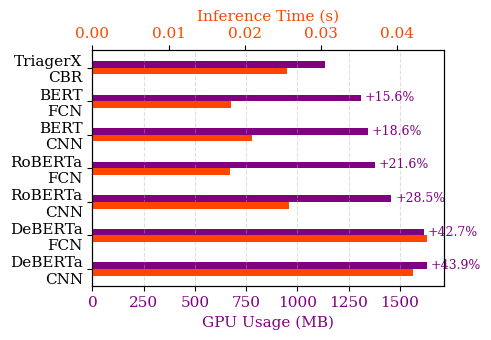

FileNotFoundError: [Errno 2] No such file or directory: '/home/mdafifal.mamun/notebooks/triagerX/notebook/times_new.ttf'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager

# Set serif font
plt.rcParams["font.family"] = "serif"
font_path = "/home/mdafifal.mamun/notebooks/triagerX/times.ttf"
if font_path:
    font_manager.fontManager.addfont(font_path)
    plt.rcParams["font.sans-serif"] = "Times New Roman"

# Data
gpu_data = [
    {"model": "RoBERTa\nCNN", "avg_time_s": 0.0258, "avg_mem_MB": 1457.26},
    {"model": "RoBERTa\nFCN", "avg_time_s": 0.0181, "avg_mem_MB": 1378.93},
    {"model": "DeBERTa\nCNN", "avg_time_s": 0.0421, "avg_mem_MB": 1631.81},
    {"model": "DeBERTa\nFCN", "avg_time_s": 0.0439, "avg_mem_MB": 1617.79},
    {"model": "BERT\nCNN", "avg_time_s": 0.0210, "avg_mem_MB": 1344.47},
    {"model": "BERT\nFCN", "avg_time_s": 0.0182, "avg_mem_MB": 1310.383},
    {"model": "TriagerX\nCBR", "avg_time_s": 0.0255, "avg_mem_MB": 1133.74}
]

bar1_color = "purple"
bar2_color = "orangered"

df = pd.DataFrame(gpu_data)

# Reference values from TriagerX
ref_time = df[df["model"] == "TriagerX\nCBR"]["avg_time_s"].values[0]
ref_mem = df[df["model"] == "TriagerX\nCBR"]["avg_mem_MB"].values[0]

# Compute percentage change vs TriagerX
df["mem_diff"] = ((df["avg_mem_MB"] - ref_mem) / ref_mem) * 100
df["time_diff"] = ((df["avg_time_s"] - ref_time) / ref_time) * 100

# Sort by memory usage for consistent plotting
df = df.sort_values("avg_mem_MB")
models = df["model"]
y = np.arange(len(models))
bar_width = 0.2

fig, ax1 = plt.subplots(figsize=(5, 3.5))

# Plot memory usage
bars1 = ax1.barh(y - bar_width/2, df["avg_mem_MB"], height=bar_width, color=bar1_color, label="GPU Memory (MB)")
ax1.set_xlabel("GPU Usage (MB)", fontsize=11, color=bar1_color)
ax1.tick_params(axis='x', labelcolor=bar1_color, labelsize=11)
ax1.set_yticks(y)
ax1.set_yticklabels(models, fontsize=11)
ax1.invert_yaxis()
ax1.grid(axis='x', linestyle='--', alpha=0.4)

# Plot inference time on second x-axis
ax2 = ax1.twiny()
bars2 = ax2.barh(y + bar_width/2, df["avg_time_s"], height=bar_width, color=bar2_color, label="Inference Time (s)")
ax2.set_xlabel("Inference Time (s)", fontsize=11, color=bar2_color)
ax2.tick_params(axis='x', labelcolor=bar2_color, labelsize=11)

# Annotate bars with absolute values and percentage differences
for i, (mem, mem_pct, time, time_pct) in enumerate(zip(df["avg_mem_MB"], df["mem_diff"], df["avg_time_s"], df["time_diff"])):
    if i != 0:
        # Memory annotation
        mem_label = f"{mem/1024:.2f} GB"
        pct_mem_label = f"{mem_pct:+.1f}%"
        ax1.text(mem + 20, y[i] - bar_width/2, pct_mem_label, va='center', ha='left', fontsize=9, color=bar1_color)

        # Time annotation
        time_label = f"{time:.4f} s"
        pct_time_label = f" ({time_pct:+.1f}%)"
        # ax2.text(time + 0.001, y[i] + bar_width/1.2, time_label + pct_time_label, va='center', ha='left', fontsize=9, color=bar2_color)

# Title, legend, layout
fig.tight_layout()
plt.savefig('gpu-utilization-with-percentage.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager

font_path = "/home/mdafifal.mamun/notebooks/triagerX/notebook/times_new.ttf"
font_manager.fontManager.addfont(font_path)

print(font_manager.fontManager.ttflist)

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman Cyr"
# plt.rcParams["text.usetex"] = True

# Data
models = ["CodeBERT\n(FCN)", "CodeBERT\n(CNN)", "TriagerX CBR", "BERT-L\n(FCN)", "BERT-L\n(CNN)", 
          "RoBERTa-L\n(FCN)", "RoBERTa-L\n(CNN)", "DeBERTa-L\n(FCN)", "DeBERTa-L\n(CNN)"]
parameters = [125.4, 129.2, 271.33, 336.1, 340.8, 356.37, 361.09, 407.22, 410.89]
top1_accuracy = [0.224, 0.159, 0.355, 0.255, 0.271, 0.267, 0.247, 0.285, 0.251]

# Normalize for better visual range
params_norm = np.array(parameters) / max(parameters)
accuracy_norm = np.array(top1_accuracy) / max(top1_accuracy)

# Set up polar plot
angles = np.linspace(0, 2 * np.pi, len(models), endpoint=False).tolist()
angles += angles[:1]  # Closing the circle
params_norm = np.concatenate((params_norm, [params_norm[0]]))  # Closing the circle
accuracy_norm = np.concatenate((accuracy_norm, [accuracy_norm[0]]))  # Closing the circle

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.spines['polar'].set_visible(False)

# Plot the parameters and accuracy with filled areas
ax.fill(angles, params_norm, color='red', alpha=0.25, label='Parameters')
ax.fill(angles, accuracy_norm, color='blue', alpha=0.25, label='Top-1 Accuracy')

# Add labels to each axis (models)
ax.set_yticklabels([])  # Remove radial labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(models, fontsize=16)

# Adjust annotation positions to fit inside the fills
for i, (angle, param, acc) in enumerate(zip(angles[:-1], parameters, top1_accuracy)):
    deltax = 0.1
    deltay = 0.1

    if i == 4:
        deltax = 0
    # Keep parameter labels inside the fill by moving them inward (subtract 0.05 from the normalized value)
    ax.text(angle, params_norm[i] - deltax, f'{param:.1f}M', color='red', fontsize=16, ha='center')  # Keep parameter annotation inside
    # Keep accuracy labels closer to the center by moving them further inward (subtract 0.15 from the normalized value)
    ax.text(angle, accuracy_norm[i] - deltay, f'{acc:.3f}', color='blue', fontsize=16, ha='center')  # Keep accuracy annotation inside

# Title and legend
plt.legend(loc='upper right', fontsize=16, bbox_to_anchor=(1.2, 1.2))
plt.savefig('acc-vs-params.pdf', bbox_inches='tight', pad_inches=0)

# plt.grid(False)
# Show plot
plt.tight_layout()
plt.show()


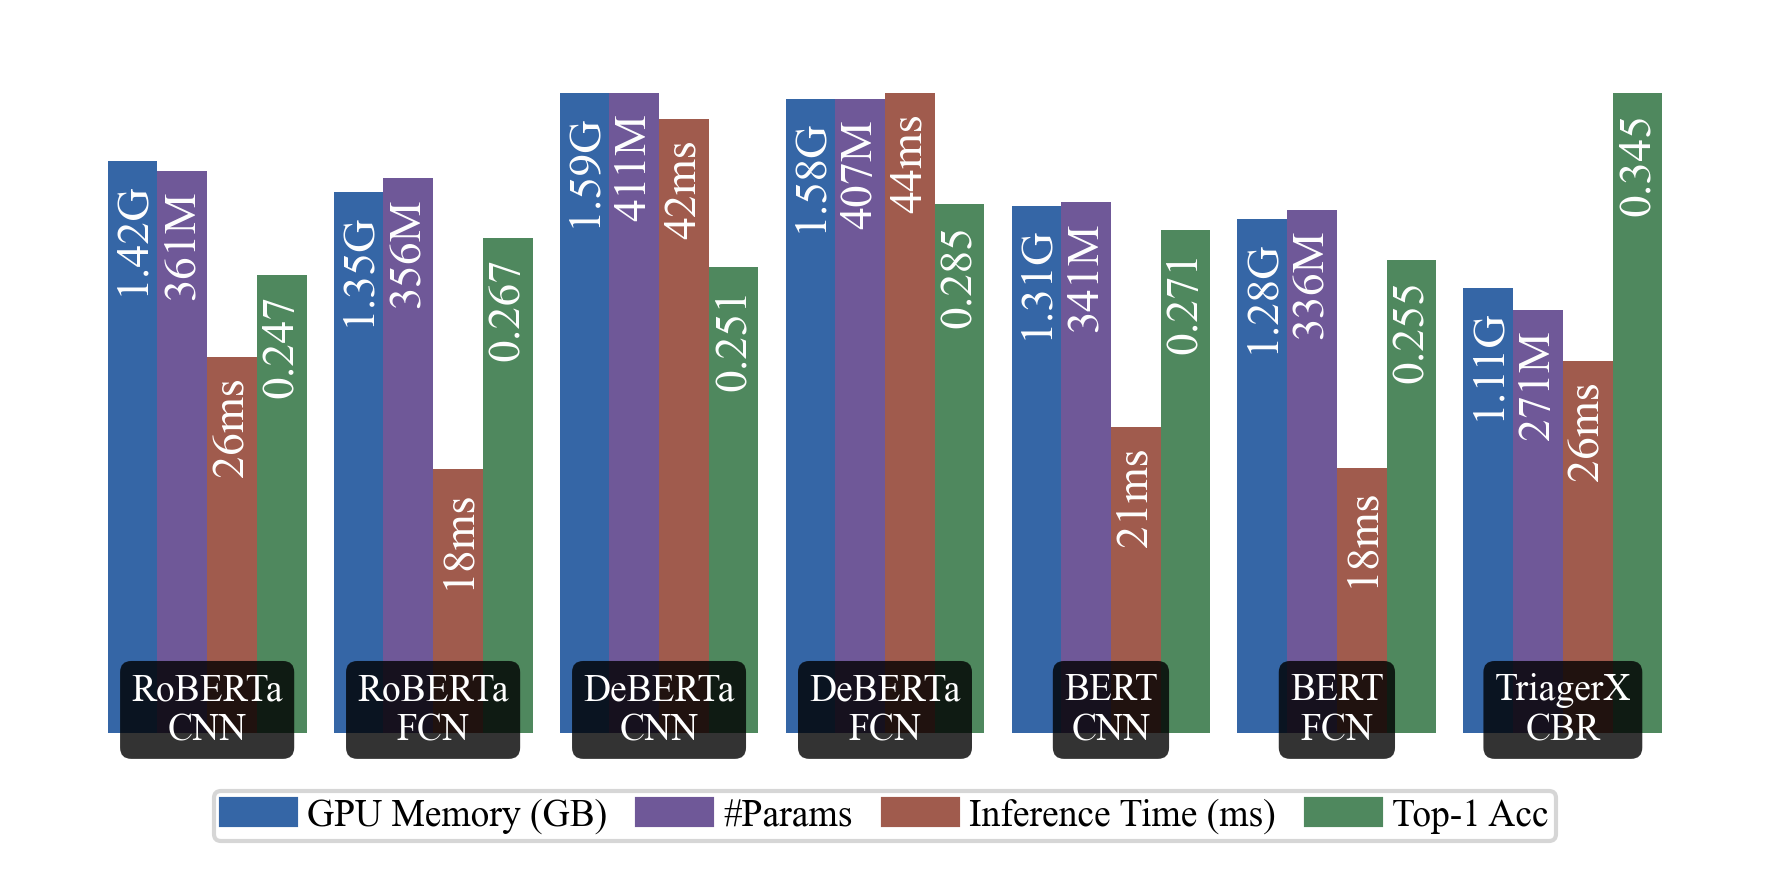

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager

# === Font setup ===
plt.rcParams["font.family"] = "serif"
font_path = "/home/mdafifal.mamun/notebooks/triagerX/times.ttf"
font_manager.fontManager.addfont(font_path)
plt.rcParams["font.serif"] = "Times New Roman"


# === Data ===
data = [
    {"model": "RoBERTa\nCNN",  "time": 0.0258, "mem": 1457.26, "param": 361.09, "acc": 0.247},
    {"model": "RoBERTa\nFCN",  "time": 0.0181, "mem": 1378.93, "param": 356.37, "acc": 0.267},
    {"model": "DeBERTa\nCNN",  "time": 0.0421, "mem": 1631.81, "param": 410.89, "acc": 0.251},
    {"model": "DeBERTa\nFCN",  "time": 0.0439, "mem": 1617.79, "param": 407.22, "acc": 0.285},
    {"model": "BERT\nCNN",     "time": 0.0210, "mem": 1344.47, "param": 340.8,  "acc": 0.271},
    {"model": "BERT\nFCN",     "time": 0.0182, "mem": 1310.38, "param": 336.1,  "acc": 0.255},
    {"model": "TriagerX\nCBR", "time": 0.0255, "mem": 1133.74, "param": 271.33, "acc": 0.345},
    # {"model": "CodeBERT\nCNN", "time": 0.0087,   "mem": 517.32,    "param": 129.2,  "acc": 0.159},
    # {"model": "CodeBERT\nFCN", "time": 0.0073,   "mem": 496.25,    "param": 125.4,  "acc": 0.224}
]

df = pd.DataFrame(data)
df.fillna(0, inplace=True)
models = df["model"]
x = np.arange(len(models))

# === Normalize for bar heights ===
mem_norm = df["mem"] / df["mem"].max()
time_norm = df["time"] / df["time"].max()
param_norm = df["param"] / df["param"].max()
acc_norm = df["acc"] / df["acc"].max()

# === Colors ===
colors = [
    "#3566A6",  # Deep Moss Green (GPU Memory)
    "#6F5898",  # Medium Green (Model Params)
    "#A05B4D",  # Warm Brown (Inference Time)
    "#4F885E"   # Muted Slate Blue (Top-1 Accuracy)
]

# === Plot setup ===
fig, ax = plt.subplots(figsize=(6, 3), dpi=300)

bar_width = 0.22

# Bars: mem, time, param, acc (acc last)
# Bars: mem, param, time, acc (acc still last)
ax.bar(x - 1.5*bar_width, mem_norm, width=bar_width, color=colors[0], label="GPU Memory")
ax.bar(x - 0.5*bar_width, param_norm, width=bar_width, color=colors[1], label="Model Params")
ax.bar(x + 0.5*bar_width, time_norm, width=bar_width, color=colors[2], label="Inference Time")
bars_acc = ax.bar(x + 1.5*bar_width, acc_norm, width=bar_width, color=colors[3], label="Top-1 Accuracy")

# === Vertical Text Annotations (inside bars) ===
# for i in range(len(x)):
#     if df["mem"][i] > 0:
#         ax.text(x[i] - 1.5*bar_width, mem_norm[i] - 0.03, f'{df["mem"][i]/1024:.2f}G',
#                 ha='center', va='top', fontsize=7, color='white', rotation=90, fontweight='bold')
#     if df["time"][i] > 0:
#         ax.text(x[i] - 0.5*bar_width, time_norm[i] - 0.03, f'{df["time"][i]*1000:.0f}ms',
#                 ha='center', va='top', fontsize=7, color='white', rotation=90, fontweight='bold')
#     ax.text(x[i] + 0.5*bar_width, param_norm[i] - 0.03, f'{df["param"][i]:.0f}M',
#             ha='center', va='top', fontsize=7, color='white', rotation=90, fontweight='bold')
#     ax.text(x[i] + 1.5*bar_width, acc_norm[i] - 0.03, f'{df["acc"][i]:.3f}',
#             ha='center', va='top', fontsize=7, color='white', rotation=90, fontweight='bold')

for i in range(len(x)):
    if df["mem"][i] > 0:
        ax.text(x[i] - 1.5*bar_width, mem_norm[i] - 0.03, f'{df["mem"][i]/1024:.2f}G',
                ha='center', va='top', fontsize=11, color='white', rotation=90, fontweight='bold')
    ax.text(x[i] - 0.5*bar_width, param_norm[i] - 0.03, f'{df["param"][i]:.0f}M',
            ha='center', va='top', fontsize=11, color='white', rotation=90, fontweight='bold')
    if df["time"][i] > 0:
        ax.text(x[i] + 0.5*bar_width, time_norm[i] - 0.03, f'{df["time"][i]*1000:.0f}ms',
                ha='center', va='top', fontsize=11, color='white', rotation=90, fontweight='bold')
    ax.text(x[i] + 1.5*bar_width, acc_norm[i] - 0.03, f'{df["acc"][i]:.3f}',
            ha='center', va='top', fontsize=11, color='white', rotation=90, fontweight='bold')


# === Clean axis ===
ax.set_ylim(0, 1.1)
ax.yaxis.set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.tick_params(bottom=False)

# Model labels below bars with spacing
for i in range(len(x)):
    ax.text(x[i], 0.095, models[i], fontsize=9, ha='center', color="white", va='top',  
            bbox=dict(facecolor='black', alpha=0.8, boxstyle='round, pad=0.3', edgecolor='none'), fontweight='semibold')


# === Legend ===
handles = [
    plt.Rectangle((0, 0), 1, 1, color=colors[0]),
    plt.Rectangle((0, 0), 1, 1, color=colors[1]),
    plt.Rectangle((0, 0), 1, 1, color=colors[2]),
    plt.Rectangle((0, 0), 1, 1, color=colors[3]),
]
labels = ["GPU Memory (GB)", "#Params", "Inference Time (ms)", "Top-1 Acc"]
ax.legend(
    handles, labels,
    fontsize=9,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.18),
    ncol=4,
    frameon=True,
    columnspacing=0.8,   # Reduce space between columns
    handletextpad=0.3,   # Reduce space between handle and text
    borderpad=0.2,       # Reduce padding inside legend box
    labelspacing=0.3
)

plt.tight_layout()
plt.savefig("final-paper-plot-acc-last-bar.pdf", bbox_inches="tight", pad_inches=0)
plt.show()


In [ ]:
data = [
    {"model": "RoBERTa\nCNN",  "time": 0.0258, "mem": 1457.26, "param": 361.09, "acc": 0.247},
    {"model": "RoBERTa\nFCN",  "time": 0.0181, "mem": 1378.93, "param": 356.37, "acc": 0.267},
    {"model": "DeBERTa\nCNN",  "time": 0.0421, "mem": 1631.81, "param": 410.89, "acc": 0.251},
    {"model": "DeBERTa\nFCN",  "time": 0.0439, "mem": 1617.79, "param": 407.22, "acc": 0.285},
    {"model": "BERT\nCNN",     "time": 0.0210, "mem": 1344.47, "param": 340.8,  "acc": 0.271},
    {"model": "BERT\nFCN",     "time": 0.0182, "mem": 1310.38, "param": 336.1,  "acc": 0.255},
    {"model": "TriagerX\nCBR", "time": 0.0255, "mem": 1133.74, "param": 271.33, "acc": 0.345},
]

SyntaxError: invalid character '✅' (U+2705) (1825307495.py, line 3)